# Data insight

In [1]:
from app.utils import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(12)

In [2]:
dataset, labels = load_dataset("../dataset/train")

label_to_category = {}
with open("../dataset/labels.txt", "r") as f:
    for line in f.readlines():
        if line != "\n":
            label, category = line.split(":")
            label_to_category[int(label)] = category.strip(" \n")

info = []
for img, label in zip(dataset, labels):
    info.append([label, label_to_category[label], img.shape[0], img.shape[1]])
    
df = pd.DataFrame(info, columns=["label", "category", "width", "height"])
df


,label,category,width,height
0,48,igloo,192,155
1,16,arbre,205,177
2,28,goutte,157,109
3,40,coccinelle,182,193
4,9,point d'exclamation,182,118
...,...,...,...,...
280,24,oiseau,164,195
281,26,ying yang,240,241
282,4,clown,140,133
283,40,coccinelle,132,138


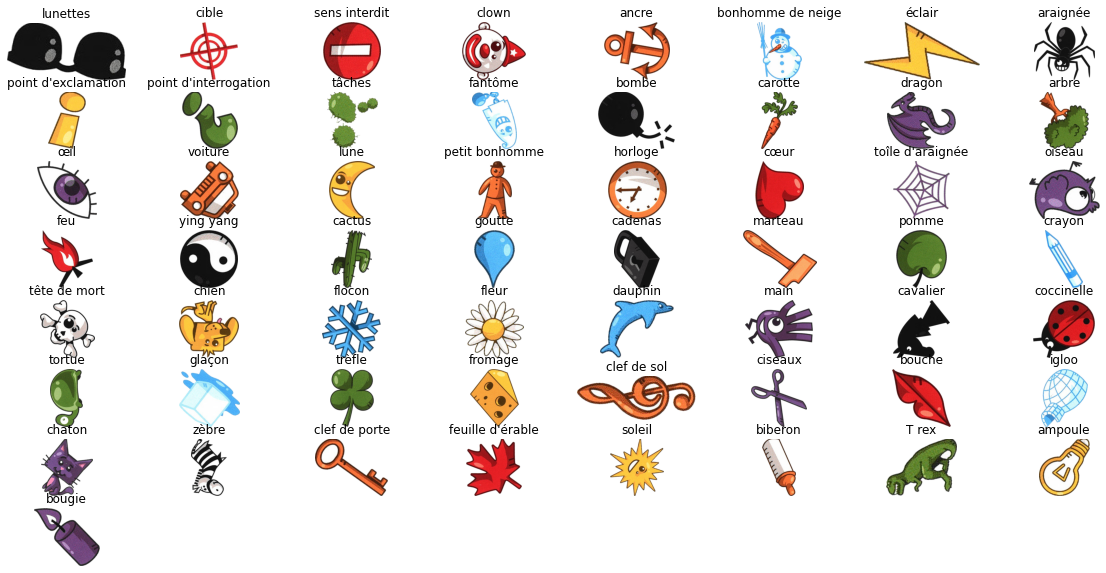

In [3]:
# Different colors + rotation are performed
plt.figure(figsize=(20,10))

for i in range(1, len(label_to_category) + 1):
    plt.subplot(8, 8, i)
    plt.title(label_to_category[i])
    idx = np.where(np.array(labels) == i)[0][0]
    plt.imshow(dataset[idx])
    plt.axis('off')

plt.show()

In [4]:
# Few samples per class => need for data augmentation
df.groupby("category").count()["label"]

category
T rex                    5
ampoule                  5
ancre                    5
araignée                 5
arbre                    5
biberon                  5
bombe                    5
bonhomme de neige        5
bouche                   5
bougie                   5
cactus                   5
cadenas                  5
carotte                  5
cavalier                 5
chaton                   5
chien                    5
cible                    5
ciseaux                  5
clef de porte            5
clef de sol              5
clown                    5
coccinelle               5
crayon                   5
cœur                     5
dauphin                  5
dragon                   5
fantôme                  5
feu                      5
feuille d'érable         5
fleur                    5
flocon                   5
fromage                  5
glaçon                   5
goutte                   5
horloge                  5
igloo                    5
lune               

In [5]:
# Different shape => may need to reshape all of it ? 
df.describe()

,label,width,height
count,285.000000,285.000000,285.000000
mean,29.000000,199.691228,194.575439
std,16.480889,59.894944,56.456877
min,1.000000,71.000000,80.000000
25%,15.000000,157.000000,155.000000
50%,29.000000,195.000000,192.000000
75%,43.000000,236.000000,225.000000
max,57.000000,398.000000,418.000000


In [6]:
tmp_dataset_aug, tmp_labels_aug = dataset_augmentation([dataset[42]], [labels[42]], transformation_per_image=1)

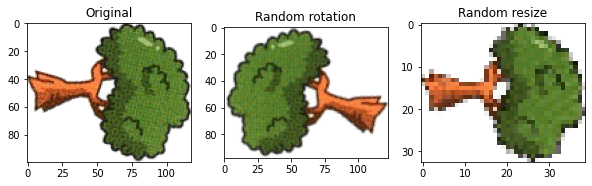

In [7]:
# Different colors + rotation are performed
plt.figure(figsize=(10,10))

plt.subplot(1, 3, 1)
plt.imshow(tmp_dataset_aug[0])
plt.title("Original")
plt.subplot(1, 3, 2)
plt.title("Random rotation")
plt.imshow(tmp_dataset_aug[1])
plt.subplot(1, 3, 3)
plt.title("Random resize")
plt.imshow(tmp_dataset_aug[2])

plt.show()

train_test_split()

In [8]:
from sklearn.model_selection import train_test_split

print(f"Original dataset = {len(dataset)}")
dataset_aug, labels_aug = dataset_augmentation(dataset, labels, transformation_per_image=1)
print(f"Augmented dataset = {len(dataset_aug)}")
img_train, img_test, label_train, label_test = train_test_split(dataset_aug, labels_aug, test_size=0.2, random_state=42, stratify=labels_aug)
print(f"Train size = {len(img_train)}")
print(f"Test size = {len(img_test)}")


Original dataset = 285
Augmented dataset = 855
Train size = 684
Test size = 171


# Orb

- To extract shape feature, we will use the Oriented FAST and Rotated BRIEF (ORB) which is basically a fusion of:
    - FAST (Features from Accelerated Segment Test) for keypoints detector => **Scale invariant**
    - rBRIEF (Rotation-aware Binary Robust Independent Elementary Features) for descriptors computation => **Rotation invariant**
- On top of being open-source, ORB is said to be faster than its counterparts SIFT and SURF 

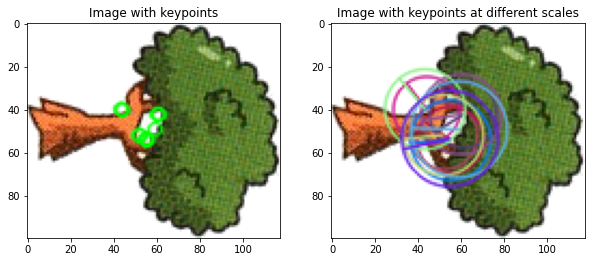

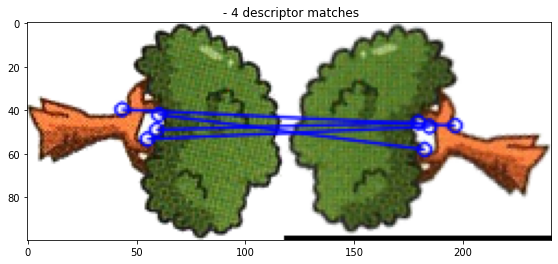

In [15]:
original = tmp_dataset_aug[0]
rotated = tmp_dataset_aug[1] 

orb = cv2.ORB_create(nfeatures=20, scaleFactor=1.2)

# Detect keypoints of original image
(kp1,des1) = orb.detectAndCompute(original, None)

# Display keypoints with/without size & orientation
kp1_without_size = np.copy(original)
kp1_with_size = np.copy(original)
cv2.drawKeypoints(original, kp1, kp1_without_size, color = (0, 255, 0))
cv2.drawKeypoints(original, kp1, kp1_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

fx, plots = plt.subplots(1, 2, figsize=(10,5))
plots[0].set_title("Image with keypoints")
plots[0].imshow(kp1_without_size, cmap='gray')
plots[1].set_title("Image with keypoints at different scales")
plots[1].imshow(kp1_with_size, cmap='gray')

# Detect keypoints of rotated image
(kp2,des2) = orb.detectAndCompute(rotated, None)

# Create matcher to show that descriptors are properly computed
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
bf.add([des1,des2])
matches = bf.match(des1,des2)

def draw_matches(img1, kpts1, img2, kpts2, matches, color=(0,0,255), title=""):
    '''img1 and img2 are color images.'''
    img_matches = np.empty((max(img1.shape[0], img2.shape[0]),
                           img1.shape[1]+img2.shape[1], 
                           3), 
                           dtype=np.uint8)
    img_matches = cv2.drawMatches(img1, kpts1, img2, kpts2, 
                          matches, 
                          img_matches,
                          matchColor=color,
                          flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(12,4))
    plt.imshow(img_matches)
    plt.title(title + " - %d descriptor matches" % (len(matches),))

draw_matches(original, kp1, rotated, kp2, matches)